In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
from flax.linen.initializers import zeros as nn_zeros
import optax
import pymbar
import sys
import jax_amber_tanh_align as jax_amber
import pickle

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from jax.scipy.stats.multivariate_normal import logpdf

import json

from flax.linen.initializers import lecun_normal

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [2]:
default_kernel_init = lecun_normal()

RT = jnp.float32(8.3144621E-3 * 300.0)
beta = jnp.float32(1.0)/RT
nm2ang = jnp.float32(10.0)
ang2nm = jnp.float32(0.1)

def get_energy_values(x, ener_funs, R0):
    ener_nHO_fun, ener_wHO_fun, ener_bond_fun = ener_funs
    enr_bnd = jax.vmap(ener_bond_fun)(x)
    enr_nHO = jax.vmap(ener_nHO_fun)(x)
    enr_wHO = jax.vmap(ener_wHO_fun, in_axes=(0, None))(x, R0)
    return enr_bnd, enr_wHO

def get_trajectory (fname_prmtop, fname_dcd, nsamp):
    import mdtraj as md

    c = md.load (fname_dcd, top=fname_prmtop)
    c = c.superpose(c)
    crds = jnp.array (c.xyz)
    return crds[-nsamp:], crds[:-nsamp] # in nm unit

class AfflineCoupling(nn.Module):
    input_size: int
    i_dim: int
    hidden_layers: int
    hidden_dim: int

    @nn.compact
    def __call__(self, inputs, reverse=False):

        fixed_mask = jnp.ones((self.input_size), dtype=jnp.int32).reshape(-1, 3)
        fixed_mask = fixed_mask.at[:, self.i_dim].set(0)
        moved_mask = jnp.int32(1) - fixed_mask
        moved_mask = moved_mask.reshape(1, -1)
        fixed_mask = fixed_mask.reshape(1, -1)
        y = inputs * fixed_mask

        for _ in range(self.hidden_layers):
            y = nn.relu(nn.Dense(features=self.hidden_dim, kernel_init=default_kernel_init)(y))

        log_scale = nn.Dense(features=self.input_size, kernel_init=nn_zeros)(y)
        shift = nn.Dense(features=self.input_size, kernel_init=nn_zeros)(y)
        shift = shift * moved_mask
        log_scale = log_scale * moved_mask

        if reverse:
            log_scale = -log_scale
            outputs = (inputs - shift) * jnp.exp(log_scale)
        else:
            outputs = inputs * jnp.exp(log_scale) + shift

        return outputs, log_scale


class realNVP3(nn.Module):
    input_size: int
    hidden_layers: int
    hidden_dim: int

    def setup(self):

        self.af_x = AfflineCoupling(self.input_size, i_dim=0,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)
        self.af_y = AfflineCoupling(self.input_size, i_dim=1,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)
        self.af_z = AfflineCoupling(self.input_size, i_dim=2,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)

    @nn.compact
    def __call__(self, inputs, reverse=False):
        n_conf, n_atoms, n_dim = inputs.shape

        outputs = inputs.reshape(n_conf, -1)
        if reverse:
            outputs, log_J_z = self.af_z(outputs, reverse)
            outputs, log_J_y = self.af_y(outputs, reverse)
            outputs, log_J_x = self.af_x(outputs, reverse)
        else:
            outputs, log_J_x = self.af_x(outputs)
            outputs, log_J_y = self.af_y(outputs)
            outputs, log_J_z = self.af_z(outputs)

        return outputs.reshape(n_conf, n_atoms, n_dim), \
            (log_J_x + log_J_y + log_J_z).sum(axis=-1)

    
class NNflows(nn.Module):
    input_size: int
    hidden_layers: int
    hidden_dim: int

    def setup(self):

        self.af_x = AfflineCoupling(self.input_size, i_dim=0,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)
        self.af_y = AfflineCoupling(self.input_size, i_dim=1,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)
        self.af_z = AfflineCoupling(self.input_size, i_dim=2,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)

        self.af_x2 = AfflineCoupling(self.input_size, i_dim=0,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)
        self.af_y2 = AfflineCoupling(self.input_size, i_dim=1,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)
        self.af_z2 = AfflineCoupling(self.input_size, i_dim=2,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)

        self.af_x3 = AfflineCoupling(self.input_size, i_dim=0,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)
        self.af_y3 = AfflineCoupling(self.input_size, i_dim=1,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)
        self.af_z3 = AfflineCoupling(self.input_size, i_dim=2,
                                    hidden_layers=self.hidden_layers,
                                    hidden_dim=self.hidden_dim)

        #self.blocks = [[self.af_x, self.af_ym self.af_z], [self.af_x2, self.af_y2, self.af_z2], [self.af_x3, self.af_y3, self.af_z3]

    @nn.compact
    def __call__(self, inputs, reverse=False):
        n_conf, n_atoms, n_dim = inputs.shape

        outputs = inputs.reshape(n_conf, -1)
        if reverse:
            outputs, log_J_z3 = self.af_z3(outputs, reverse)
            outputs, log_J_y3 = self.af_y3(outputs, reverse)
            outputs, log_J_x3 = self.af_x3(outputs, reverse)

            outputs, log_J_z2 = self.af_z2(outputs, reverse)
            outputs, log_J_y2 = self.af_y2(outputs, reverse)
            outputs, log_J_x2 = self.af_x2(outputs, reverse)

            outputs, log_J_z = self.af_z(outputs, reverse)
            outputs, log_J_y = self.af_y(outputs, reverse)
            outputs, log_J_x = self.af_x(outputs, reverse)
        else:
            outputs, log_J_x = self.af_x(outputs)
            outputs, log_J_y = self.af_y(outputs)
            outputs, log_J_z = self.af_z(outputs)

            outputs, log_J_x2 = self.af_x2(outputs)
            outputs, log_J_y2 = self.af_y2(outputs)
            outputs, log_J_z2 = self.af_z2(outputs)

            outputs, log_J_x3 = self.af_x3(outputs)
            outputs, log_J_y3 = self.af_y3(outputs)
            outputs, log_J_z3 = self.af_z3(outputs)

        return outputs.reshape(n_conf, n_atoms, n_dim), \
            (log_J_x + log_J_y + log_J_z + log_J_x2 + log_J_y2 + log_J_z2 + log_J_x3 + log_J_y3 + log_J_z3).sum(axis=-1)
    
    
    
    
def rmsf(x):
    n, m, k = x.shape

    # Calculate the average positions over all frames
    avg_positions = jnp.mean(x, axis=0)

    # Calculate the deviations for each atom at each frame
    rmsf = jnp.sqrt(jnp.sum((x - avg_positions[None, :, :])**2)/m)

    # Calculate the RMSF for each atom by taking the root mean square of the deviations over all frames


    return rmsf


def get_gaussian_energy(x, x_A_flat_mean, x_A_flat_cov, factor):
    x_flat = x.reshape([x.shape[0], x.shape[1] * x.shape[2]])

    enr_gaus = -logpdf(x_flat, x_A_flat_mean, x_A_flat_cov/factor)

    return enr_gaus

def main(x_A, tx_A, R0_A, result = 'A.txt'):
    with open(result, 'w') as file:
        file.write('start\n')
    
    rng = jax.random.PRNGKey(0)
    rng, x_key, tx_key = jax.random.split(rng, num=3)

    x_A_flat = x_A.reshape([x_A.shape[0], x_A.shape[1] * x_A.shape[2]])
    x_A_mean = jnp.mean(x_A, axis=0)
    x_A_flat_mean = jnp.mean(x_A_flat, axis=0)
    x_A_flat_cov_oring = jnp.cov(x_A_flat, rowvar=False)
    x_A_flat_cov = x_A_flat_cov_oring + 0.1 * jnp.diag(x_A_flat_cov_oring).min() * jnp.eye(x_A_flat_cov_oring.shape[0])

    fixed_atoms = jnp.array(json_data['fixed']['atoms']) - 1
    #R0_A = jnp.array(json_data['fixed']['R0_A'])
    kval = jnp.float32(json_data['fixed']['kval'])

    nconf = x_A.shape[0]

    input_size = x_A.shape[1] * 3
    hidden_dim = json_data['realNVP']['hidden_dim']
    hidden_layers = json_data['realNVP']['hidden_layers']

    model = NNflows(input_size=input_size,
                     hidden_layers=hidden_layers,
                     hidden_dim=hidden_dim)
    ener_funs = jax_amber.get_amber_energy_funs(json_data['fname_prmtop'],
                                                fixed_atoms[-1],
                                                kval)
    _, ener_wHO_fun, ener_bond_fun = ener_funs

    _, enr_bnd_A0, enr_wHO_A0 = get_energy_values(x_A, ener_funs, R0_A)

    _, tenr_bnd_A0, tenr_wHO_A0 = get_energy_values(tx_A, ener_funs, R0_A)

    lr = json_data['optax']['learning_rate']
    total_steps = json_data['optax']['total_steps']
    alpha = json_data['optax']['alpha']
    scheduler = optax.cosine_decay_schedule(lr,
                                            decay_steps=total_steps,
                                            alpha=alpha)

    opt_method = optax.chain(
        optax.clip(1.0),
        optax.adam(learning_rate=scheduler)
    )

    state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=model.init(rng, x_A)['params'],
        tx=opt_method
    )

    fixed_R0 = (R0_A)

    loss_hist = []
    loss_oring_hist = []
    loss_oring_f_hist = []
    loss_f_hist = []
    loss_b_hist = []
    loss_oring_b_hist = []

    tm_A_hist = []
    m_A_hist = []
    tm_B_hist = []

    switch_gear = []
    iterations = 0

    state_hist_full = []

    for multip in jnp.arange(30):
        switch_gear.append(iterations)

        factor = 5 * (0.9 ** multip)
        
        #factor = 1
        # if multip == 8:
        # factor = 1

        #if multip == 11:
            #factor = 1
        # factor = 1

        print(factor)

        x_B_flat = jax.random.multivariate_normal(x_key, x_A_flat_mean, x_A_flat_cov / factor, (x_A.shape[0],),
                                                  method='svd')
        tx_B_flat = jax.random.multivariate_normal(tx_key, x_A_flat_mean, x_A_flat_cov / factor, (tx_A.shape[0],),
                                                   method='svd')
        # x_B_flat = jax.random.multivariate_normal(x_key, x_A_flat_mean, jnp.eye(x_A_flat_mean.shape[0]) / factor, [x_A.shape[0]])
        # tx_B_flat = jax.random.multivariate_normal(tx_key, x_A_flat_mean, jnp.eye(x_A_flat_mean.shape[0]) / factor, [x_A.shape[0]])

        x_B = x_B_flat.reshape(x_A.shape)
        tx_B = tx_B_flat.reshape(tx_A.shape)

        def get_gaussian_energy(x):
            x_flat = x.reshape([x.shape[0], x.shape[1] * x.shape[2]])

            enr_gaus = -logpdf(x_flat, x_A_flat_mean, x_A_flat_cov / factor)

            return enr_gaus

        enr_B0 = get_gaussian_energy(x_B)
        tenr_B0 = get_gaussian_energy(tx_B)

        ener_ref0 = \
            (enr_wHO_A0, enr_B0, enr_bnd_A0)

        tener_ref0 = \
            (tenr_wHO_A0, tenr_B0, tenr_bnd_A0)

        def loss_value(ener_wHO_fn, ener_bond_fn, enr0_wHO, m_B, log_J_F, m_A, log_J_R, fixed_R0):
            enr_wHO_A0, enr_B0, _ = enr0_wHO
            R0_A = fixed_R0

            enr_A = jax.vmap(ener_wHO_fn, in_axes=(0, None))(m_A, R0_A)

            # m_B_flat = m_B.reshape([m_B.shape[0], m_B.shape[1] * m_B.shape[2]])
            # enr_B = logpdf(m_B_flat, mean=mean, cov=cov)
            enr_B = get_gaussian_energy(m_B)

            # enr_bnd_A = jax.vmap(ener_bond_fn) (m_A)

            loss_F = beta * (enr_B - enr_wHO_A0) - log_J_F
            loss_R = beta * (enr_A - enr_B0) - log_J_R

            loss = loss_F.mean() + loss_R.mean()

            return loss, loss_F, loss_R

        @jax.jit
        def train_step(state, inputs, ener_wHO_ref0, fixed_R0):
            def loss_fn(params, apply_fn):
                x_A, x_B = inputs

                m_B, log_J_F = apply_fn({'params': params}, x_A)
                m_A, log_J_R = apply_fn({'params': params}, x_B, reverse=True)

                loss, _, _ = loss_value(ener_wHO_fun, ener_bond_fun, ener_wHO_ref0,
                                        m_B, log_J_F, m_A, log_J_R, fixed_R0)

                return loss

            grads = jax.grad(loss_fn)(state.params, state.apply_fn)

            return state.apply_gradients(grads=grads)

        state_hist = []
        for epoch in range(50000):

            iterations += 1
            # for ist0 in range(0, nconf, 200):
            #    ied0 = ist0 + 200
            #    ied0 = jnp.where(ied0 < nconf, ied0, nconf)
            #    batch = (x_A[ist0:ied0], x_B[ist0:ied0])
            #    ener_wHO_ref0 = (enr_wHO_A0[ist0:ied0], enr_B0[ist0:ied0],
            #                     enr_bnd_A0)

            #    state = train_step(state, batch, ener_wHO_ref0, fixed_R0)
            rng, x_key= jax.random.split(rng, num=2)
            choice = jax.random.choice(x_key, 8000, shape = [500])
            batch = (x_A[choice], x_B[choice])
            
            ener_wHO_ref0 = (enr_wHO_A0[choice], enr_B0[choice],
                                 enr_bnd_A0)
            #batch = (x_A, x_B)
            #ener_wHO_ref0 = (enr_wHO_A0, enr_B0, enr_bnd_A0)
            state = train_step(state, batch, ener_wHO_ref0, fixed_R0)

            if (epoch) % 100 == 0:
                state_hist.append(state.params)

                tm_B, tlog_J_F = state.apply_fn({'params': state.params}, tx_A)

                tm_A, tlog_J_R = state.apply_fn({'params': state.params}, tx_B, reverse=True)

                loss, loss_f, loss_b = loss_value(ener_wHO_fun, ener_bond_fun, tener_ref0,
                                                  tm_B, tlog_J_F, tm_A, tlog_J_R, fixed_R0)

                loss_hist.append(loss.item())
                loss_f_hist.append(loss_f.mean().item())
                loss_b_hist.append(loss_b.mean().item())
                
                with open(result, 'a') as file:
                    file.write('factor: ' + str(factor) + ' epoch: '+ str(epoch) + '\n loss: ' + str(loss) + '\n')
                    file.write('forward: '+ str(loss_f.mean()) + ' backward: ' + str(loss_b.mean()) + '\n')

                m_B, log_J_F = state.apply_fn({'params': state.params}, x_A)

                m_A, log_J_R = state.apply_fn({'params': state.params}, x_B, reverse=True)
                
                if epoch>2000:
                
                    last5 = loss_hist[-5:-1]
                    last5_2 = loss_hist[-4:]

                    last5_b = loss_b_hist[-5:-1]
                    last5_b_2 = loss_b_hist[-4:]
                    
                    last5_f = loss_f_hist[-5:-1]
                    last5_f_2 = loss_f_hist[-4:]
                    
                    if loss_hist[-1] >= 10000:
                        state = state.replace (params=test_ckpt['params'],opt_state=test_ckpt['opt_state'])

                        break
                        
                    if loss_f_hist[-1] >= 10000:
                        state = state.replace (params=test_ckpt['params'],opt_state=test_ckpt['opt_state'])
                        break
                        
                    if loss_b_hist[-1] >= 10000:
                        state = state.replace (params=test_ckpt['params'],opt_state=test_ckpt['opt_state'])
                        break

                    if (np.mean(last5_f) + 2*np.abs(np.mean(last5_f))) <= np.mean(last5_f_2):

                        break

                    if epoch > 4000:

                        if np.mean(last5) <= np.mean(last5_2):
                            if np.mean(last5_b) <= np.mean(last5_b_2):
                                break
                                
                test_ckpt = {'params': state.params, 
                            'opt_state':state.opt_state}




                        
                #if epoch%1000 == 0:
                    #print(epoch, loss)

        state_hist_full.append(state_hist)


    return state_hist_full, [x_A_flat_mean, x_A_flat_cov]


def get_BAR(x_A, a, parm, R0_A, factor, dimh = 25, depth = 3):

    input_size = x_A.shape[1] * 3
    hidden_dim = dimh
    hidden_layers = depth

    model = NNflows(input_size=input_size,
                     hidden_layers=hidden_layers,
                     hidden_dim=hidden_dim)

    opt_method = optax.chain(
        optax.clip(1.0),
        optax.adam(learning_rate=1e-5)
    )

    state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=model.init(rng, x_A)['params'],
        tx=opt_method
    )

    fixed_atoms = jnp.array(json_data['fixed']['atoms']) - 1
    kval = jnp.float32(json_data['fixed']['kval'])

    ener_funs = jax_amber.get_amber_energy_funs(json_data['fname_prmtop'],
                                                fixed_atoms[-1],
                                                kval)

    _, ener_wHO_fun, ener_bond_fun = ener_funs

    x_B_flat = jax.random.multivariate_normal(tx_key, parm[0], parm[1]/factor, (x_A.shape[0],), method='svd')
    x_B = x_B_flat.reshape(x_A.shape)

    enr_bnd_A0, enr_wHO_A0 = get_energy_values(x_A, ener_funs, R0_A)
    enr_wHO_B0 = get_gaussian_energy(x_B, parm[0], parm[1], factor)

    m_B, log_J_F = state.apply_fn({'params': a}, x_A)
    m_A, log_J_R = state.apply_fn({'params': a}, x_B, reverse=True)

    enr_bond_A, enr_wHO_A = get_energy_values(m_A, ener_funs, R0_A)
    enr_wHO_B = get_gaussian_energy(m_B, parm[0], parm[1], factor)

    dU_F = enr_wHO_B - enr_wHO_A0
    dU_R = enr_wHO_A - enr_wHO_B0
    phi_F = beta * dU_F - log_J_F
    phi_R = beta * dU_R - log_J_R

    f_BAR_wHO = pymbar.bar(phi_F, phi_R,
                           relative_tolerance=1.0e-5,
                           verbose=False,
                           compute_uncertainty=False)
    
    f_FEP_wHO = pymbar.exp(phi_F, compute_uncertainty = False)

    return RT*f_BAR_wHO['Delta_f'], RT*f_FEP_wHO['Delta_f'], [phi_F, phi_R]


def valuegetter(x_A, R0_A, addon, dimh, depth):
    with open(f'{addon}.pkl', "rb") as file:
        # Load the pickled object
        state_A, parmA = pickle.load(file)
        
        
    A_energy = []
    B_energy = []
    A_energyf = []
    B_energyf = []
    phi_hist_A = []
    phi_hist_B = []
    for i in range(len(state_A)):
        factor = 5 * (0.9 ** i)
        A1, A2, A3 = get_BAR(x_A, state_A[i][-1], parmA, R0_A, factor, dimh, depth)
        A_energy.append(A1)
        A_energyf.append(A2)
        phi_hist_A.append(A3)
        
    return A_energy
    

2023-09-06 23:39:10.275569: W external/xla/xla/service/gpu/nvptx_compiler.cc:564] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.1.105). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
fname_json = 'F18_20_align/input_test.json'

with open(fname_json) as f:
    json_data = json.load(f)

fout = open(json_data['fname_log'], 'w', 1)

R0_A = jnp.array(json_data['fixed']['R0_A'])
R0_B = jnp.array(json_data['fixed']['R0_B'])

rng = jax.random.PRNGKey(0)
rng, x_key, tx_key = jax.random.split(rng, num=3)

x_A, tx_A = get_trajectory(json_data['fname_prmtop'],
                              json_data['fname_dcd_A'],
                              8000)

x_B, tx_B = get_trajectory(json_data['fname_prmtop'],
                              json_data['fname_dcd_B'],
                              8000)

In [3]:
addon = 'h,d,n=50,5,3'

with open(f'A{addon}.pkl', "rb") as file:
    # Load the pickled object
    state_A, parmA = pickle.load(file)
with open(f'B{addon}.pkl', "rb") as file:
    # Load the pickled object
    state_B, parmB = pickle.load(file)

In [5]:
A_energy = []
B_energy = []
A_energyf = []
B_energyf = []
phi_hist_A = []
phi_hist_B = []
for i in range(len(state_A)):
    factor = 5 * (0.9 ** i)
    A1, A2, A3 = get_BAR(tx_A, state_A[i][-1], parmA, R0_A, factor, 50, 5)
    A_energy.append(A1)
    A_energyf.append(A2)
    phi_hist_A.append(A3)
for i in range(len(state_A)):
    factor = 5 * (0.9 ** i)
    B1, B2, B3 = get_BAR(tx_B, state_B[i][-1], parmB, R0_B, factor, 50, 5)
    B_energy.append(B1)
    B_energyf.append(B2)
    phi_hist_B.append(B3)

Text(0.5, 1.0, 'absolute free energy evolution')

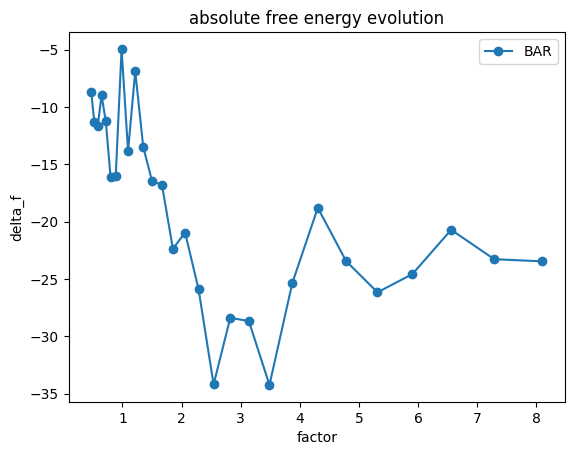

In [6]:
x = 10*(0.9**np.arange(len(state_A)))
plt.plot(x[2:], jnp.array(A_energy[2:]) - jnp.array(B_energy[2:]), marker = 'o', label = 'BAR')
#plt.plot(x,jnp.array(A_energyf) - jnp.array(B_energyf), marker = 'o', label = 'FEP')
plt.xlabel('factor')
plt.ylabel('delta_f')
#plt.yscale('log')
plt.legend()
plt.title('absolute free energy evolution')

In [4]:
fname_json = 'F18_20_align/input_test.json'

with open(fname_json) as f:
    json_data = json.load(f)

fout = open(json_data['fname_log'], 'w', 1)

R0_A = jnp.array(json_data['fixed']['R0_A'])
R0_B = jnp.array(json_data['fixed']['R0_B'])

rng = jax.random.PRNGKey(0)
rng, x_key, tx_key = jax.random.split(rng, num=3)

x_A, tx_A = get_trajectory(json_data['fname_prmtop'],
                              json_data['fname_dcd_A'],
                              8000)

x_B, tx_B = get_trajectory(json_data['fname_prmtop'],
                              json_data['fname_dcd_B'],
                              8000)

In [4]:
A_energy = valuegetter(x_A, R0_A, 'Ah,d,n=128,3,3', 128, 3)
B_energy = valuegetter(x_B, R0_B, 'Bh,d,n=128,3,3', 128, 3)

Text(0.5, 1.0, 'absolute free energy evolution')

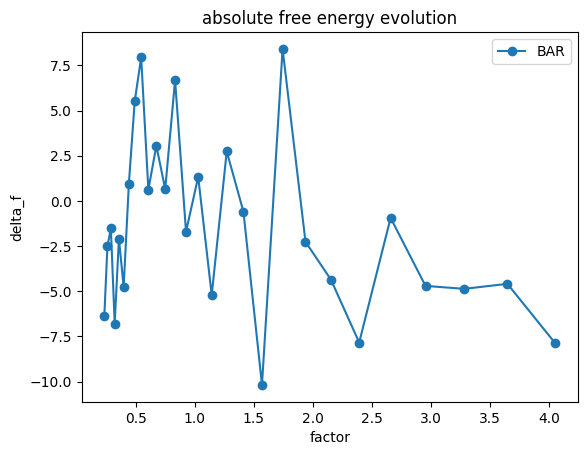

In [5]:
x = 5*(0.9**np.arange(len(A_energy)))
plt.plot(x[2:], jnp.array(A_energy[2:]) - jnp.array(B_energy[2:]), marker = 'o', label = 'BAR')
#plt.plot(x,jnp.array(A_energyf) - jnp.array(B_energyf), marker = 'o', label = 'FEP')
plt.xlabel('factor')
plt.ylabel('delta_f')
#plt.yscale('log')
plt.legend()
plt.title('absolute free energy evolution')

In [6]:
A_energy = valuegetter(x_A, R0_A, 'Ah,d,n=128,3,3,shifted', 128, 3)
B_energy = valuegetter(x_B, R0_B, 'Bh,d,n=128,3,3,shifted', 128, 3)

Text(0.5, 1.0, 'absolute free energy evolution')

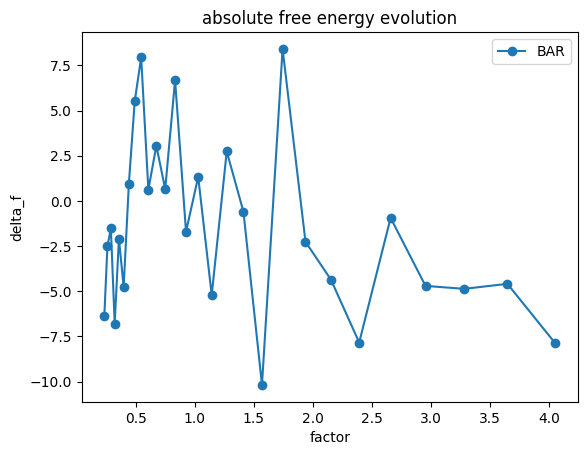

In [7]:
x = 5*(0.9**np.arange(len(A_energy)))
plt.plot(x[2:], jnp.array(A_energy[2:]) - jnp.array(B_energy[2:]), marker = 'o', label = 'BAR')
#plt.plot(x,jnp.array(A_energyf) - jnp.array(B_energyf), marker = 'o', label = 'FEP')
plt.xlabel('factor')
plt.ylabel('delta_f')
#plt.yscale('log')
plt.legend()
plt.title('absolute free energy evolution')

In [9]:
A_energy = valuegetter(x_A, R0_A, 'Ah,d,n=128,3,3,decay0.9', 128, 3)
B_energy = valuegetter(x_B, R0_B, 'Bh,d,n=128,3,3,decay0.9', 128, 3)

Text(0.5, 1.0, 'absolute free energy evolution')

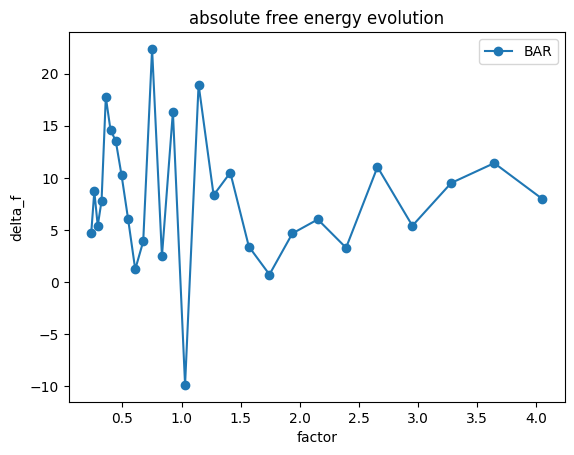

In [10]:
x = 5*(0.9**np.arange(len(A_energy)))
plt.plot(x[2:], jnp.array(A_energy[2:]) - jnp.array(B_energy[2:]), marker = 'o', label = 'BAR')
#plt.plot(x,jnp.array(A_energyf) - jnp.array(B_energyf), marker = 'o', label = 'FEP')
plt.xlabel('factor')
plt.ylabel('delta_f')
#plt.yscale('log')
plt.legend()
plt.title('absolute free energy evolution')

In [12]:
A_energy = valuegetter(x_A, R0_A, 'Ah,d,n=128,3,3,decay1000', 128, 3)
B_energy = valuegetter(x_B, R0_B, 'Bh,d,n=128,3,3,decay1000', 128, 3)

Text(0.5, 1.0, 'absolute free energy evolution')

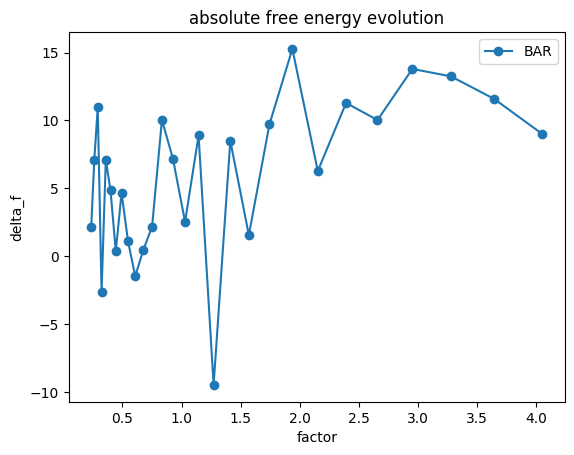

In [13]:
x = 5*(0.9**np.arange(len(A_energy)))
plt.plot(x[2:], jnp.array(A_energy[2:]) - jnp.array(B_energy[2:]), marker = 'o', label = 'BAR')
#plt.plot(x,jnp.array(A_energyf) - jnp.array(B_energyf), marker = 'o', label = 'FEP')
plt.xlabel('factor')
plt.ylabel('delta_f')
#plt.yscale('log')
plt.legend()
plt.title('absolute free energy evolution')

In [14]:
A_energy = valuegetter(x_A, R0_A, 'Ah,d,n=128,10,3', 128, 10)
B_energy = valuegetter(x_B, R0_B,'Bh,d,n=128,10,3', 128, 10)

Text(0.5, 1.0, 'absolute free energy evolution')

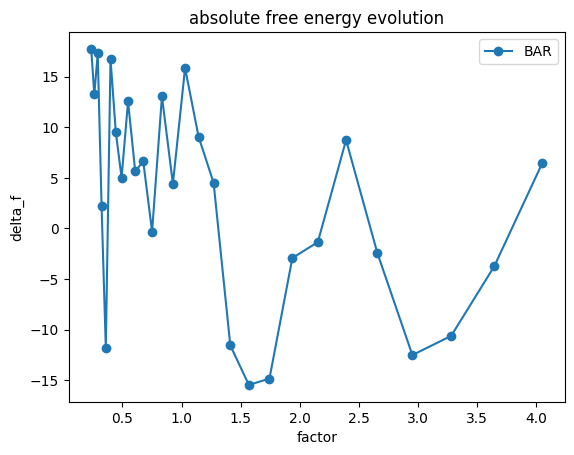

In [15]:
x = 5*(0.9**np.arange(len(A_energy)))
plt.plot(x[2:], jnp.array(A_energy[2:]) - jnp.array(B_energy[2:]), marker = 'o', label = 'BAR')
#plt.plot(x,jnp.array(A_energyf) - jnp.array(B_energyf), marker = 'o', label = 'FEP')
plt.xlabel('factor')
plt.ylabel('delta_f')
#plt.yscale('log')
plt.legend()
plt.title('absolute free energy evolution')

In [5]:
A_energy = valuegetter(x_A, R0_A, 'Ah,d,n=128,3,3,nobatch', 128, 3)
B_energy = valuegetter(x_B, R0_B,'Bh,d,n=128,3,3,nobatch', 128, 3)

Text(0.5, 1.0, 'absolute free energy evolution')

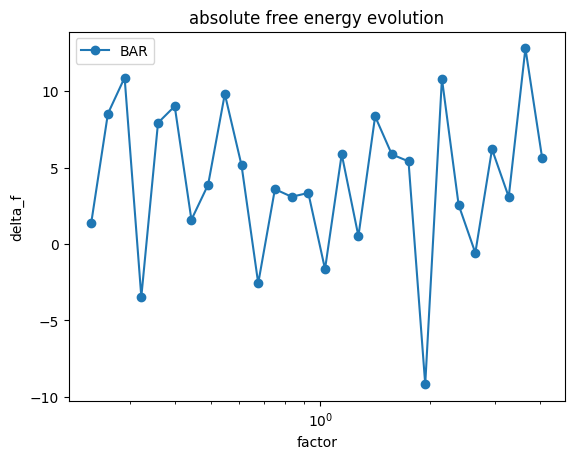

In [7]:
x = 5*(0.9**np.arange(len(A_energy)))
plt.plot(x[2:], jnp.array(A_energy[2:]) - jnp.array(B_energy[2:]), marker = 'o', label = 'BAR')
#plt.plot(x,jnp.array(A_energyf) - jnp.array(B_energyf), marker = 'o', label = 'FEP')
plt.xlabel('factor')
plt.ylabel('delta_f')
#plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('absolute free energy evolution')

In [14]:
A_energy = valuegetter(x_A, R0_A, 'Ah,d,n=128,3,3,lesslr', 128, 3)
B_energy = valuegetter(x_B, R0_B,'Bh,d,n=128,3,3,lesslr', 128, 3)

Text(0.5, 1.0, 'absolute free energy evolution')

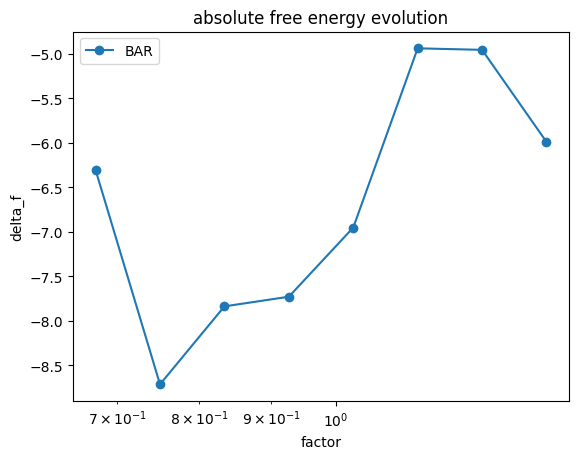

In [17]:
x = 5*(0.9**np.arange(len(A_energy)))
plt.plot(x[12:], jnp.array(A_energy[12:]) - jnp.array(B_energy[12:]), marker = 'o', label = 'BAR')
#plt.plot(x,jnp.array(A_energyf) - jnp.array(B_energyf), marker = 'o', label = 'FEP')
plt.xlabel('factor')
plt.ylabel('delta_f')
#plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('absolute free energy evolution')

In [9]:
A_energy = valuegetter(x_A, R0_A, 'Ah,d,n=128,3,3,leaky,lesslr', 128, 3)
B_energy = valuegetter(x_B, R0_B,'Bh,d,n=128,3,3,leaky,lesslr', 128, 3)

Text(0.5, 1.0, 'absolute free energy evolution')

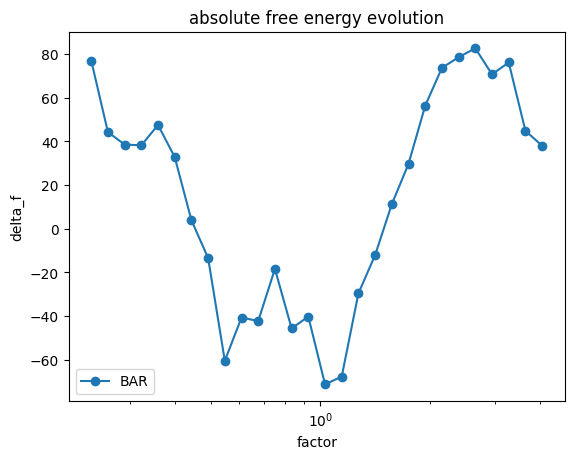

In [10]:
x = 5*(0.9**np.arange(len(A_energy)))
plt.plot(x[2:], jnp.array(A_energy[2:]) - jnp.array(B_energy[2:]), marker = 'o', label = 'BAR')
#plt.plot(x,jnp.array(A_energyf) - jnp.array(B_energyf), marker = 'o', label = 'FEP')
plt.xlabel('factor')
plt.ylabel('delta_f')
#plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('absolute free energy evolution')

In [11]:
A_energy = valuegetter(x_A, R0_A, 'Ah,d,n=128,3,3,swish', 128, 3)
B_energy = valuegetter(x_B, R0_B,'Bh,d,n=128,3,3,swish', 128, 3)

Text(0.5, 1.0, 'absolute free energy evolution')

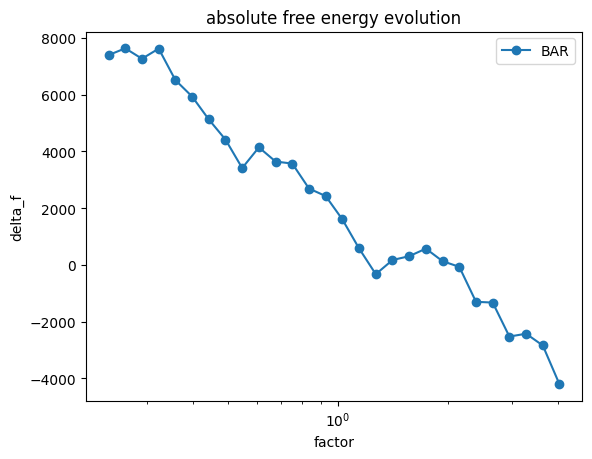

In [12]:
x = 5*(0.9**np.arange(len(A_energy)))
plt.plot(x[2:], jnp.array(A_energy[2:]) - jnp.array(B_energy[2:]), marker = 'o', label = 'BAR')
#plt.plot(x,jnp.array(A_energyf) - jnp.array(B_energyf), marker = 'o', label = 'FEP')
plt.xlabel('factor')
plt.ylabel('delta_f')
#plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('absolute free energy evolution')